<a href="https://colab.research.google.com/github/Flamisell/StewartPlatformGTI_py/blob/main/Stewart_GTI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal design of a Stewart platform using the global transmission index under determinate constraint of workspace


---

This repository is the application of the Research article
first published online October 23, 2017 :

"*Optimal design of a Stewart platform using the global transmission index under determinate constraint of workspace* "
(https://doi.org/10.1177/168781401772088) (https://journals.sagepub.com/doi/10.1177/1687814017720880)


You can use this repository to find the optimal configuration of your Stewart Platform based on the maximization of the Global Transmission Index. In this article, screw theory is used to find the transmissability indexes: "*The transmissibility indexes describe the transmission ability from the joint force to the platform movement.*"

The big advantage of this paper is the possibility to optimise the joint configuration of the parallel manipulator based on frame-free and unit homogeneous indexes.


- Due to ne natural frame-dependence of the Jacobian, each index coming from it will be directly dependent on the position in space of the platform : "*Thus, those evaluation indexes share common drawbacks such as frame-dependent property and the unit inhomogeneous problem*". Because the Transmission Index is based on power transmission, which is a scalar, we can solve such drawbacks: "*Thus, this kind of evaluation indexes is frame-free and unit homogeneous.*"


---






# Explanation and Procedure

In the following part of the Colab sheet, the replication of the analysis presented in the paper is carried out.

## Explanation of Screw Theory and Global Transmission Index

Super quick review of Screw Theory.

A screw can be used to describe the movement of a rigid body, usually called twist screw, and also can be used to describe the generalized force applied on a rigid body named wrench screw.


*The physical significance of the reciprocal product is the instantaneous power generated by the wrench screw
 on the rigid body which is moving under the motion described by the twist screw
. The reciprocal product between the twist screw St and the wrench screw Sw is the instantaneous power generated by the two screws.*

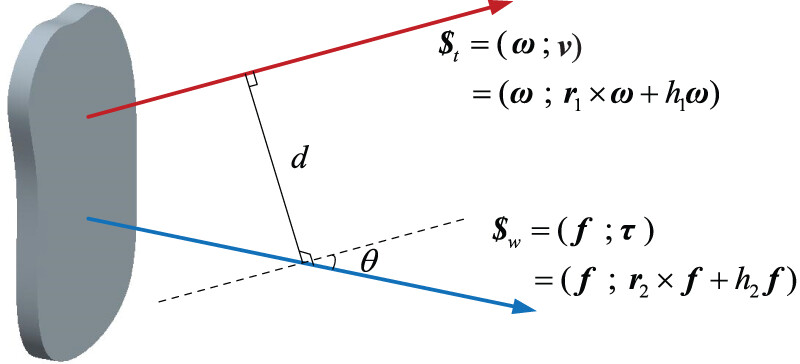

The instantaneous power can be defined as:

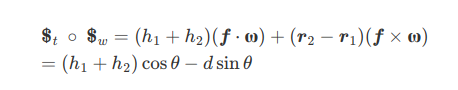

*For most mechanisms, the prime function is to transmit motion from the input joint to the output joint and the end effector, so the motion of the output joint and the end effector caused by the movement of the input joint represented in screw format is called the output twist screw (OTS). Similarly, the external load exerted on the output joint and the end effector is transmitted to the input joint, so the internal wrench caused by the external load represented in screw format is called the transmission wrench screw (TWS).*



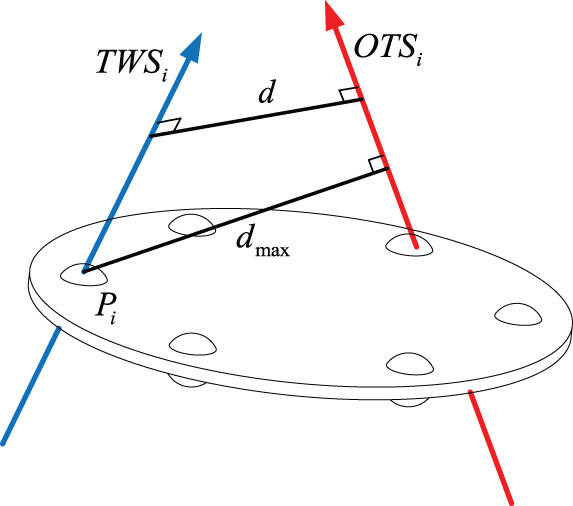

The definition of TI (transmission index) for spatial mechanisms is the ratio of instantaneous power and the maximum power generated by the unit TWS (Transmission Wrench Screw Sw) and OTS (Output Twist Screw St) on a rigid body. Hence, the TI between TWS and OTS can be represented as

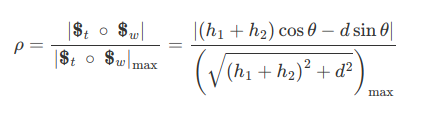

We can then integrate the transmission index TI , in the whole workspace to obtain a Global Transmission Index relative to the platform joint configuration [r_b, r_p , phi_p , phi_b]. We can then vary the joint configuration to find the configuration which maximises the Global Transmission Index.

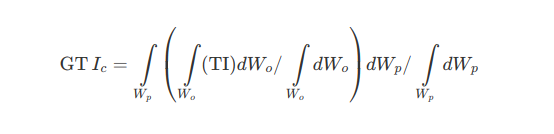

We will use the Stewart Platform Class previously made in my other repository to define the platform and calculate the Global Transmission Index in the whole workspace.

## Stewart Platform Class



Defines the stewart platform object.

In [74]:
# @title Stewart Platform Class
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

class StewartPlatform:

    def __init__(self, r_b , phi_b , r_p, phi_p):
        self.r_b = r_b # radius of base
        self.phi_b = phi_b # angle between base joints
        self.r_p = r_p # radius of platform
        self.phi_p = phi_p # angle between platform joints
        self.options = {
            1: self.getSingularValueIndex,
            2: self.getManipulabilityIndex,
            3: self.getConditionNumber,
            4: self.getLocalConditionIndex,
            5: self.getLDI,
            6: self.getLocalConditionIndexT
        }


    ############################################ IK ##############################################
    def __inverse_kinematics(self, pose): ## Inverse Kinematics (Vectorial Closing Loop)
        if len(pose) != 6:
            raise ValueError("Pose must be a 6-element list or array")

        self.p_i = np.zeros([6, 3])
        self.b_i = np.zeros([6, 3])
        self.l_i = np.zeros([6, 3])
        self.l_i_unit = np.zeros([6, 3])

        self.pose_vect = pose
        x_p, y_p, z_p, roll, pitch, yaw = pose

        self.r = R.from_euler("ZYX", (yaw, pitch, roll), degrees=True)  #rotation matrix
        angles = np.array([0, 120, 120, 240, 240, 0])

        for i in range(6):
            j = -1 if (i % 2) == 1 else 1
            self.b_i[i, 0] = self.r_b * np.cos(np.deg2rad(angles[i] + j * self.phi_b / 2)) # base points
            self.b_i[i, 1] = self.r_b * np.sin(np.deg2rad(angles[i] + j * self.phi_b / 2))
            self.p_i[i, 0] = self.r_p * np.cos(np.deg2rad(angles[i] + j * self.phi_p / 2)) # platform points
            self.p_i[i, 1] = self.r_p * np.sin(np.deg2rad(angles[i] + j * self.phi_p / 2))
            self.l_i[i, :] = np.array([x_p, y_p, z_p]) + self.r.as_matrix().dot(self.p_i[i]) - self.b_i[i] # legs vectors
            self.l_i_unit[i, :] = self.l_i[i, :] / np.linalg.norm(self.l_i[i, :]) # unit legs vectors
            self.p_i[i] = self.l_i[i, :] + self.b_i[i] # moving platform points wrt base frame

        return self.l_i

    def getIK(self, pose):
        return self.__inverse_kinematics(pose)

    ############################################ Jacobian ##############################################
    def __jacobian(self): # Calculate Jacobian q_dot=Jacobian*x_dot
        if not hasattr(self, 'l_i_unit') or not hasattr(self, 'p_i'):
            raise AttributeError("Run inverse kinematics before calculating the Jacobian")
        self.jacobian = np.zeros([6, 6])
        for i in range(6):
            lastcols = np.cross(self.r.as_matrix().dot(self.p_i[i]), self.l_i_unit[i])
            self.jacobian[i, :3] = self.l_i_unit[i]
            self.jacobian[i, 3:] = lastcols

        return self.jacobian

    def getJacobian(self):
        return self.__jacobian()

    ############################################ FK ##############################################
    def __forward_kinematics(self, starting_pose, lengths_desired, plot_flag): # Newton Method Optimization.
        if not isinstance(starting_pose, (list, np.ndarray)) or len(starting_pose) != 6:
            raise ValueError("Starting pose must be a list or numpy array with 6 elements")
        if not isinstance(lengths_desired, (list, np.ndarray)) or len(lengths_desired) != 6:
            raise ValueError("Lengths desired must be a list or numpy array with 6 elements")

        self.pose_vect = starting_pose
        x_p, y_p, z_p, roll, pitch, yaw = starting_pose
        self.r = R.from_euler("ZYX", (yaw, pitch, roll), degrees=True)

        # Newton Method Parameters
        max_count = 100
        epsilon = 0.001
        alpha_pos = 0.2
        alpha_rot = 0.5
        # variables
        est_pose_vect = np.copy(starting_pose)
        est_pose = np.zeros([4, 4])
        est_pose[:3, :3] = self.r.as_matrix()
        est_pose[:3, 3] = [x_p, y_p, z_p]
        est_pose[3, 3] = 1
        delta_lengths = np.zeros(6)
        delta_T = np.identity(4)
        error = epsilon + 1
        count = 0

        while error > epsilon and count < max_count:
            # find new variables
            legs_est = self.__inverse_kinematics(est_pose_vect)
            lengths_est = np.linalg.norm(legs_est, axis=1)
            delta_lengths = lengths_desired - lengths_est
            J = self.__jacobian()
            J_T = J.transpose()
            # find x_delta with pseudoinverse
            J_star = np.linalg.inv(J_T.dot(J) + 0.0001 * np.identity(6)).dot(J_T)
            x_delta = np.dot(J_star, delta_lengths)
            x_delta_pos = x_delta[:3] * alpha_pos
            x_delta_rot = x_delta[3:] * alpha_rot
            # transform x_delta to delta_T
            r_delta = R.from_euler("ZYX", x_delta_rot)
            delta_T[:3, :3] = r_delta.as_matrix()
            delta_T[:3, 3] = x_delta[:3]
            # move pose
            est_pose = np.dot(delta_T, est_pose)
            # transform est_pose to est_pose_vect
            est_pose_vect[:3] = est_pose[:3, 3]
            self.r_pos = R.from_matrix(est_pose[:3, :3])
            est_pose_vect[3:] = self.r_pos.as_euler("ZYX", degrees=True)
            # find error and update counter
            error = np.linalg.norm(delta_lengths)
            count += 1

            # Uncomment to plot during FK procedure
            if plot_flag:
              self.plot()

        if count < max_count:
            self.pose_vect = est_pose_vect
            print("Forward Kinematics converged!")
            print("Estimated pose:", est_pose_vect)
            print("Desired Lengths:", lengths_desired)
            print("Estimated Lengths:", lengths_est)
            print("Error:", error)
            print("Iterations:", count)
        else:
            print("Forward Kinematics did not converge")
            print("Estimated pose:", est_pose_vect)
            print("Desired Lengths:", lengths_desired)
            print("Estimated Lengths:", lengths_est)
            print("Error:", error)
            print("Iterations:", count)

        return self.pose_vect

    def getFK(self, starting_pose, lengths_desired, plot_flag):
        return self.__forward_kinematics(starting_pose, lengths_desired, plot_flag)

    ############################################ Kinematic Analysis ##############################################
    def __find_singular_value_index(self): # measures drive capability of the platform, finds max q_dot under unitary x_dot
        J = self.__jacobian()
        eigenvalues = np.linalg.eigvals(J.T.dot(np.linalg.inv(J)))
        sigma_max = np.abs(np.sqrt(np.max(eigenvalues)))
        return sigma_max

    def getSingularValueIndex(self):
        return self.__find_singular_value_index()

    def __find_manipulability_index(self): # Measures manipulability of manipulator, can be used to optimize it's configuration
        J = self.__jacobian()
        JJ = J.dot(J.T)
        w = np.sqrt(np.linalg.det(JJ))
        return w

    def getManipulabilityIndex(self):
        return self.__find_manipulability_index()

    def __find_condition_number(self): # Measures closeness to isotropic configuration [1,+ inf)
        J = self.__jacobian()
        cond_num = np.linalg.cond(J)
        return cond_num

    def getConditionNumber(self):
        return self.__find_condition_number()

    def __find_local_condition_index(self): # Measures closeness to isotropic configuration (0,1]
        eta = 1 / self.__find_condition_number()
        return eta

    def getLocalConditionIndex(self):
        return self.__find_local_condition_index()

    ############################################ Force Analysis ##############################################
    def __find_platform_forces(self, F_actuators): # Finds platform forces given by actuator forces
        if not isinstance(F_actuators, (list, np.ndarray)) or len(F_actuators) != 6:
            raise ValueError("F_actuators must be a list or numpy array with 6 elements")
        J_T = self.__jacobian().T
        F_platform = J_T.dot(F_actuators)
        return F_platform

    def getPlatformForces(self, F_actuators):
        return self.__find_platform_forces(F_actuators)

    def __find_actuator_forces(self, F_platform): # Finds actuator forces given by platform forces
        if not isinstance(F_platform, (list, np.ndarray)) or len(F_platform) != 6:
            raise ValueError("F_platform must be a list or numpy array with 6 elements")

        J_Inv = np.linalg.inv(self.__jacobian().T) # only when Jacobian is invertible
        F_actuators = J_Inv.dot(F_platform)
        return F_actuators

    def getActuatorForces(self, F_platform):
        return self.__find_actuator_forces(F_platform)

    def __find_force_ellipsoid(self): # Finds force ellipsoid (excluding moment vectors)
        J_T = self.__jacobian().T
        JJ = J_T.dot(J_T.T)
        A = JJ[:3, :3] # Lagrangian
        eigenvalues, eigenvectors = np.linalg.eig(A)

        Force_ellipsoid_1 = eigenvectors[:, 0] * np.abs(eigenvalues[0])
        Force_ellipsoid_2 = eigenvectors[:, 1] * np.abs(eigenvalues[1])
        Force_ellipsoid_3 = eigenvectors[:, 2] * np.abs(eigenvalues[2])

        return [Force_ellipsoid_1, Force_ellipsoid_2, Force_ellipsoid_3]

    def getForceEllipsoid(self):
        return self.__find_force_ellipsoid()

    def __find_ldi(self):  # Local design index for Force transmittability (actuator design)
        J_T = self.__jacobian().T
        JJ = J_T.dot(J_T.T)
        A = JJ[:3, :3] # Lagrangian
        eigenvalues, _ = np.linalg.eig(A)
        R_f = np.abs(np.sqrt(np.min(eigenvalues))) # take minimum magnitude of force ellipsoid for actuator design
        LDI_f = 1 / R_f # local design index
        return LDI_f

    def getLDI(self):
        return self.__find_ldi()

    def __find_local_condition_index_T(self):  # Measures closeness to isotropic force configuration (0,1] 0 is singularity.
      J_T = self.__jacobian().T
      cond_num = np.linalg.cond(J_T)
      eta_T = 1 / cond_num
      return eta_T

    def getLocalConditionIndexT(self):
      return self.__find_local_condition_index_T()

    ############################################ Workspace Analysis #########################################

    def __find_index_workspace_position(self, workspace_limits, RPY, N, choice):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(RPY, (list, np.ndarray)) or len(RPY) != 3:
            raise ValueError("RPY must be a list or array of 3 elements")
        if not isinstance(N, int) or N <= 0:
            raise ValueError("N must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space
        x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits
        roll, pitch, yaw = RPY

        # Ensure workspace limits are valid
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")

        # Discretization vectors
        try:
            x_vect = np.linspace(x_min, x_max, N)
            y_vect = np.linspace(y_min, y_max, N)
            z_vect = np.linspace(z_min, z_max, N)
        except Exception as e:
            raise ValueError(f"Error in creating discretization vectors: {e}")

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
        orientations = np.array([roll, pitch, yaw])

        Holder = []

        for pos in positions:
            p_vect = np.hstack((pos, orientations))
            try:
                self.getIK(p_vect)
                Index = self.options[choice]()
                Holder.append(np.append(pos, Index))
            except Exception as e:
                print(f"Error in calculating index for position {pos}: {e}")
                continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspacePosition(self, workspace_limits, RPY, N, choice):
        return self.__find_index_workspace_position(workspace_limits, RPY, N, choice)

    def __find_index_workspace_orientation(self, position, orientation_limits, N, choice):
        # Validate inputs
        if not isinstance(position, (list, np.ndarray)) or len(position) != 3:
            raise ValueError("position must be a list or array of 3 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N, int) or N <= 0:
            raise ValueError("N must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits

        # Ensure orientation limits are valid
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        # Discretization vectors
        try:
            roll_vect = np.linspace(roll_min, roll_max, N)
            pitch_vect = np.linspace(pitch_min, pitch_max, N)
            yaw_vect = np.linspace(yaw_min, yaw_max, N)
        except Exception as e:
            raise ValueError(f"Error in creating discretization vectors: {e}")

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        Holder = []

        for orient in orientations:
            p_vect = np.hstack((position, orient))
            try:
                self.getIK(p_vect)
                Index = self.options[choice]()
                Holder.append(np.append(orient, Index))
            except Exception as e:
                print(f"Error in calculating index for orientation {orient}: {e}")
                continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspaceOrientation(self, position, orientation_limits, N, choice):
        return self.__find_index_workspace_orientation(position, orientation_limits, N, choice)

    def __find_index_workspace(self, workspace_limits, orientation_limits, N_pos, N_orient, choice):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N_pos, int) or N_pos <= 0:
            raise ValueError("N_pos must be a positive integer")
        if not isinstance(N_orient, int) or N_orient <= 0:
            raise ValueError("N_orient must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space for positions
        x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")

        x_vect = np.linspace(x_min, x_max, N_pos)
        y_vect = np.linspace(y_min, y_max, N_pos)
        z_vect = np.linspace(z_min, z_max, N_pos)

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

        # Define discretization space for orientations
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        roll_vect = np.linspace(roll_min, roll_max, N_orient)
        pitch_vect = np.linspace(pitch_min, pitch_max, N_orient)
        yaw_vect = np.linspace(yaw_min, yaw_max, N_orient)

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        # Iterate through each position and each orientation
        Holder = []
        for pos in positions:
            for orient in orientations:
                p_vect = np.hstack((pos, orient))
                try:
                    self.getIK(p_vect)
                    Index = self.options[choice]()
                    Holder.append(np.append(p_vect, Index))
                except Exception as e:
                    print(f"Error in calculating index for position {pos} and orientation {orient}: {e}")
                    continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspace(self, workspace_limits, orientation_limits, N_pos, N_orient, choice):
        return self.__find_index_workspace(workspace_limits, orientation_limits, N_pos, N_orient, choice)

    def __find_singularity_workspace(self, workspace_limits, orientation_limits, N_pos, N_orient):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N_pos, int) or N_pos <= 0:
            raise ValueError("N_pos must be a positive integer")
        if not isinstance(N_orient, int) or N_orient <= 0:
            raise ValueError("N_orient must be a positive integer")


        # Define discretization space for positions
        x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")

        x_vect = np.linspace(x_min, x_max, N_pos)
        y_vect = np.linspace(y_min, y_max, N_pos)
        z_vect = np.linspace(z_min, z_max, N_pos)

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

        # Define discretization space for orientations
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        roll_vect = np.linspace(roll_min, roll_max, N_orient)
        pitch_vect = np.linspace(pitch_min, pitch_max, N_orient)
        yaw_vect = np.linspace(yaw_min, yaw_max, N_orient)

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        # Select 1/condition number for J_T
        choice=6

        # Iterate through each position and each orientation
        Holder = []
        for pos in positions:
            for orient in orientations:
                p_vect = np.hstack((pos, orient))
                try:
                    self.getIK(p_vect)
                    Index = self.options[choice]()
                    if Index <0.001:
                      Holder.append(np.append(p_vect, Index))
                except Exception as e:
                    print(f"Error in calculating index for position {pos} and orientation {orient}: {e}")
                    continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getSingularityWorkspace(self, workspace_limits, orientation_limits, N_pos, N_orient): # returns the value of the local condition indexT for every point in space
        # Choosing N_pos and N_orient too high may result in a computational expensive operation, suggested values ( N_pos=10, N_orient=10 )
        # for practical usage there is the need to filter the data. Suggestion: filter by local condition index value AND by distance between data points (from scipy.spatial.distance import cdist).
        return self.__find_singularity_workspace(workspace_limits, orientation_limits, N_pos, N_orient)



    ############################################ Plot Platform ##############################################
    def plot(self):
        if not hasattr(self, 'p_i'):
          raise AttributeError("Run inverse kinematics before calling the Plot function")
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title("Stewart Platform")

        ax.plot(self.p_i[:, 0], self.p_i[:, 1], self.p_i[:, 2], color='b', lw=3)
        ax.plot([self.p_i[5, 0], self.p_i[0, 0]], [self.p_i[5, 1], self.p_i[0, 1]], [self.p_i[5, 2], self.p_i[0, 2]], color='b', lw=3)
        ax.scatter(self.p_i[:, 0], self.p_i[:, 1], self.p_i[:, 2], color='c', marker='o')

        ax.plot(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], color='b')
        ax.plot([self.b_i[5, 0], self.b_i[0, 0]], [self.b_i[5, 1], self.b_i[0, 1]], [self.b_i[0, 2], self.b_i[0, 2]], color='b')
        ax.scatter(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], color='c', marker='o')

        for i in range(6):
            ax.plot([self.b_i[i, 0], self.p_i[i, 0]], [self.b_i[i, 1], self.p_i[i, 1]], [self.b_i[i, 2], self.p_i[i, 2]], color='k', lw=3)

        displacement = 0.03
        for x, y, z, i in zip(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], range(len(self.b_i[:, 0]))):
            ax.text(x + displacement, y + displacement, z, i)

        ax.quiver(0, 0, 0, 1, 0, 0, color='r', lw=0.5, length=0.2)
        ax.quiver(0, 0, 0, 0, 1, 0, color='g', lw=0.5, length=0.2)
        ax.quiver(0, 0, 0, 0, 0, 1, color='b', lw=0.5, length=0.2)

        x_limits = ax.get_xlim3d()
        y_limits = ax.get_ylim3d()
        z_limits = ax.get_zlim3d()
        x_range = abs(x_limits[1] - x_limits[0])
        x_middle = np.mean(x_limits)
        y_range = abs(y_limits[1] - y_limits[0])
        y_middle = np.mean(y_limits)
        z_range = abs(z_limits[1] - z_limits[0])
        z_middle = np.mean(z_limits)
        plot_radius = 0.5 * max([x_range, y_range, z_range])

        ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
        ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
        ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')

        plt.show()

Plotly plotting libraries

In [75]:
# @title Plotting libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Step1: Definition of the Space Docking Mechanism




In this paper a procedure for finding the optimal configuration for the Space Docking Mechanism is carried out.

For the space docking mechanism, the moving platform circle must conform to the international standard, so r_p is set as 0.363m. To calculate the GTI in the whole workspace of the manipulator, we must determine the appropriate zero position first. Here, we also **assume** the configuration parameter of the manipulator is: [r_b, phi_p , phi_b]= [0.307m, 100°, 60°].
The position of the platform in space is also set to [x, y, z, R, P, Y]= [0, 0.0, 0.2, 0, 0, 0]. Workspace limits are also defined.

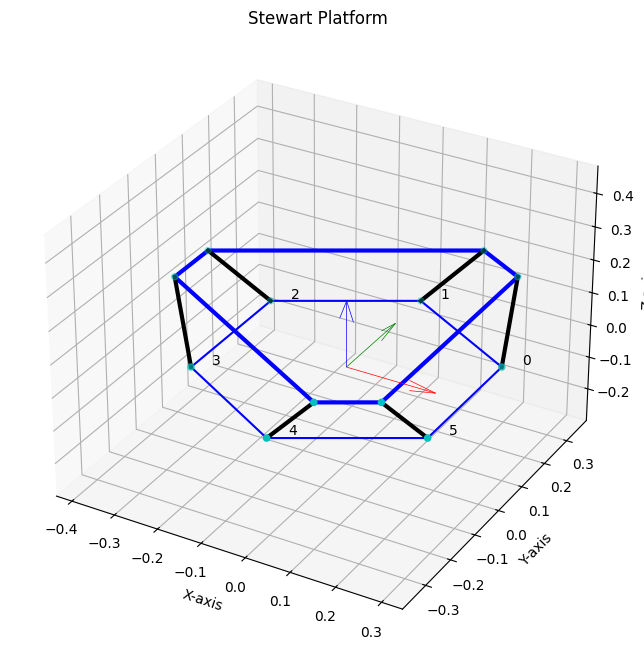

In [76]:
# Define parameters
r_p = 0.363; # Radius of platform
r_b = 0.307; # Radius of base
phi_p = 100; # Angle between platform joints
phi_b=60; # Angle between base joints


# Create Stewart Platform instance
platform = StewartPlatform(r_b, phi_b, r_p, phi_p)
pose = [0.0, 0.0, 0.18, 0, 0, 0]  # [x, y, z, roll, pitch, yaw] (removed 2 centimeters for platform thickness)
leg_lengths = platform.getIK(pose)
platform.plot()

# Save data points
base_points=platform.b_i
platform_points=platform.p_i
unit_vectors=platform.l_i_unit

workspace_limits = [-0.05,0.05,-0.05,0.05,0.15,0.5] # [x_min, x_max, y_min, y_max, z_min, z_max]
orientation_limits = [-5,5,-5,5,-5,5] # [roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max]

## Step2: Calculation of Transmission Wrench Screws

*The TWS of the branched chain of the docking mechanism is a pure force whose axis passes through the center of the S pair and U pair (platform leg mechanical joints) simultaneously. And the TWS can be expressed as:*

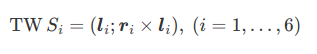

*where l_i is the unit vector of the direction of the
 branched chain, and r_i is the coordinate of arbitrary point on the
 branched chain with respect to the reference frame.*

In [77]:
# Transmission wrench screw
TWS=np.zeros([6,6])
for i in range(6):
  TWS[i,0:3]=unit_vectors[i,:]
  TWS[i,3:6]=np.cross(platform_points[i], unit_vectors[i,:])

## Step3: Obtain the Output Twist Screws of the motion of the platform

*When the Stewart manipulator is only driven by prismatic actuator
 and other prismatic actuators are locked, the Stewart manipulator becomes a single-DOF manipulator. [...] The five TWSs represented as TWS_j (j=1,...,6 and j=/i), become the constraint wrench of the moving platform, so the OTS_i is reciprocal to all the five TWSs; in this way, one can obtain the following equation:*

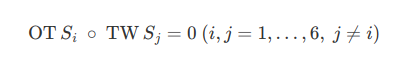

*Here, a kind of method to calculate the reciprocal screw of five given screws is introduced.*

If you are curious to learn more you can check out the paper itself as the method is a bit complex and long for this colab. I highly suggest to check it out (:

In [78]:
# Calculating Output Twist Screw (OTS)

OTS=np.zeros([6,6])
TWS_reciprocal=np.zeros([6,6]) # We need the reciprocal of the TWS
A=np.zeros([6,6]) # Matrix for the reciproval of TWS

# Compute the reciprocal of TWS
for i in range(6):
  TWS_reciprocal[i,0:3]=TWS[i,3:6]
  TWS_reciprocal[i,3:6]=TWS[i,0:3]

A=np.copy(TWS_reciprocal) # Matrix for the reciproval of TWS

# Algorithm for calculating OTS
for k in range(5, -1, -1):
  A_without_row=np.copy(np.delete(A, k, axis = 0)) # Each k iteration remove a row from the matrix.
  det_vect=np.zeros(6) # Determinant vector

  for i in range(6):
    A_local=np.copy(A_without_row)
    A_local = np.delete(A_local, i, axis = 1) # Each i iteration remove i column
    det_vect[i]=np.linalg.det(A_local) # Compute determinant of remaining 5x5 matrix

  gain=1/np.linalg.norm(np.array([-det_vect[0],det_vect[1],-det_vect[2]])) # Calculate gain
  OTS[k,:]=gain*np.array([-det_vect[0],det_vect[1],-det_vect[2],det_vect[3],-det_vect[4],det_vect[5]]) # Find OTS vector for each k iteration

You can check if the method has worked correctly by verifying the reciprocity of the two vectors. If the two vectors are reciprocal it means that their dot product will give 0 as a result.

In [79]:
#TWSi=[w,v] this lays in each joint (force from legs)
#OTSi=[w,v] this lays in the platform point center (velocity from legs on the P point)
print("Check if OTS and TWS are reciprocal with j=/i \n")
# if j =/ i
j=0;
i=1;
print("Dot product of reciprocal vectors is 0")
print("np.dot(TWS_reciprocal[j],OTS[i]): ",np.dot(TWS_reciprocal[j],OTS[i]),"\n")
print("Dot product of non-reciprocal vectors is different from 0")
print("np.dot(TWS_reciprocal[j],OTS[j]): ",np.dot(TWS_reciprocal[j],OTS[j]))


Check if OTS and TWS are reciprocal with j=/i 

Dot product of reciprocal vectors is 0
np.dot(TWS_reciprocal[j],OTS[i]):  5.551115123125783e-17 

Dot product of non-reciprocal vectors is different from 0
np.dot(TWS_reciprocal[j],OTS[j]):  0.5920283360375702


## Step4: figure out the Transmission Index (TI) when the TWS and OTS have been gotten

To calculate the Transmission Index TI we need to find the numerator and the denominator of such equation:

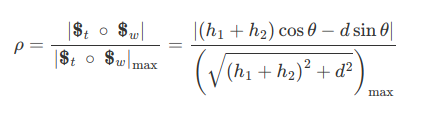

The numerator can be easily found with the dot product of TWS_j with OTS_j, for the denominator we can look directly for the max:

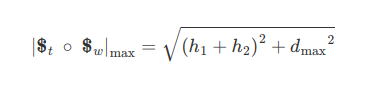

When the two screws , TWS and OTS , are given, their pitch,  h1 and h2,are thought to be constant.

To calculate d_max we firstly have to find the distance from the characteristic point of the TWS (joint platform attachment) to the axis line of the OTS. To do so we need to find the equation of the points laying on OTS vector.


In [80]:
#### Calculating Transmission Index and returning the minimum

w_OTS=np.copy(OTS[:,0:3]) # Unit vector of the rotational velocity of OTS
v_OTS=np.copy(OTS[:,3:6]) # The dual of the unit screw of OTS
d_max=np.zeros(6) # Stores max distance
d=np.zeros([6,3]) # " where d is the vector from the characteristic point Pi to arbitrary point on the axis line of the OTSi"
h1_vect=np.zeros(6) # pitch of the unit screw of TWS
h2_vect=np.zeros(6) # pitch of the unit screw of OTS
TI_vect=np.ones([6])*100 # Initializing Trasmission Index Vector

# We need a point Laying on each OTS vector.
# r x w_i = v_i - h*w_i (screw theory equation defining OTS)
# h = v_i * w_i
# r x w_i = v_i - (v_i * w_i) * w_i
r_OTS = np.zeros([6,3]) # Points will contain the point laying on OTS vector
c = np.zeros([6,3]) # Right side of cross product
h = np.zeros(6) # Pitch of OTS[i]
t=0; # Line parameter, value can be chosen freely (we will do cross products, the point has to just stay on the OTS vector)

# Calculate TI for each joint
for i in range(6):

  # Calculate points laying on OTSi vector
  # r x w_i = v_i - h*w_i
  # h = v_i * w_i
  # r x w_i = v_i - (v_i * w_i) * w_i
  # a = np.cross(b,c)/np.dot(b,b)+t*b is a solution for all t. if a and c are orthogonal
  # r_i = np.cross(w_OTS[i],c[i])/np.dot(w_OTS[i],w_OTS[i])+t*w_OTS[i] , t=0 --> r_i = np.cross(w_OTS[i],c[i])
  # where c[i] = v_i - (v_i * w_i) * w_i
  h[i]=np.dot(w_OTS[i],v_OTS[i]) # pitch of OTS[i]
  c[i]= v_OTS[i] - h[i]*w_OTS[i] # right side of cross product r x w_i = v_i - (v_i * w_i) * w_i
  r_OTS[i]=np.cross(w_OTS[i],c[i]) +t*w_OTS[i] # points laying on OTSi

  # Calculate max perpendicular distance from each platform point to their respective OTS vector
  d[i] = platform_points[i]-r_OTS[i] # " [...] where d is the vector from the characteristic point Pi to arbitrary point on the axis line of the OTSi"
  d_max[i]=np.linalg.norm(np.cross(d[i],w_OTS[i])) # max perpendicular distance from Pi to the OTS vector

  # Calculate unit pitch of TWSi and OTSi
  h1_vect[i]=np.dot(TWS_reciprocal[i,0:3],TWS_reciprocal[i,3:6]) # unit pitch of TWSi
  h2_vect[i]=np.dot(OTS[i,3:6],OTS[i,0:3]) # unit pitch of OTSi

  # Calculating TI for each joint
  numerator=np.abs(np.dot(TWS_reciprocal[i],OTS[i]))
  denominator=np.sqrt((h1_vect[i] + h2_vect[i]) ** 2 + d_max[i] ** 2)
  TI_vect[i]=numerator/denominator

# Taking the minimum Transmission Index value.
TI_min=np.min(TI_vect)

## Step5: Fathom out the OATI (orientation average transmission index) when the configuration and position of the manipulator are constant

As we need to plot TI for every orientation in our workspace, we will create a function getTI which incorporates step2, step3 and step4.

In [81]:
# @title getTI Function
def getTI(platform):
    """
    Function to calculate the Transmission Index (TI) for a given platform.
    """

    # Platform Information
    platform_points=platform.p_i # Platform points
    unit_vectors=platform.l_i_unit # Unit joint vectors

    ######################################################################################################
    # Calculating Transmission Wrench Screw (TWS)
    TWS=np.zeros([6,6])
    for i in range(6):
      TWS[i,0:3]=unit_vectors[i,:]
      TWS[i,3:6]=np.cross(platform_points[i], unit_vectors[i,:])

    ######################################################################################################

    ######################################################################################################
    # Calculating Output Twist Screw (OTS)

    OTS=np.zeros([6,6])
    TWS_reciprocal=np.zeros([6,6]) # We need the reciprocal of the TWS
    A=np.zeros([6,6]) # Matrix for the reciproval of TWS

    # Compute the reciprocal of TWS
    for i in range(6):
      TWS_reciprocal[i,0:3]=TWS[i,3:6]
      TWS_reciprocal[i,3:6]=TWS[i,0:3]

    A=np.copy(TWS_reciprocal)

    # Algorithm for calculating OTS
    for k in range(5, -1, -1):
      A_without_row=np.copy(np.delete(A, k, axis = 0)) # Each k iteration remove a row from the matrix.
      det_vect=np.zeros(6) # Determinant vector

      for i in range(6):
        A_local=np.copy(A_without_row)
        A_local = np.delete(A_local, i, axis = 1) # Each i iteration remove i column
        det_vect[i]=np.linalg.det(A_local) # Compute determinant of remaining 5x5 matrix

      gain=1/np.linalg.norm(np.array([-det_vect[0],det_vect[1],-det_vect[2]])) # Calculate gain
      OTS[k,:]=gain*np.array([-det_vect[0],det_vect[1],-det_vect[2],det_vect[3],-det_vect[4],det_vect[5]]) # Find OTS vector for each k iteration

    ######################################################################################################

    ######################################################################################################
    #### Calculating Transmission Index and returning the minimum

    w_OTS=np.copy(OTS[:,0:3]) # Unit vector of the rotational velocity of OTS
    v_OTS=np.copy(OTS[:,3:6]) # The dual of the unit screw of OTS
    d_max=np.zeros(6) # Stores max distance
    d=np.zeros([6,3]) # " where d is the vector from the characteristic point Pi to arbitrary point on the axis line of the OTSi"
    h1_vect=np.zeros(6) # pitch of the unit screw of TWS
    h2_vect=np.zeros(6) # pitch of the unit screw of OTS
    TI_vect=np.ones([6])*100 # Initializing Trasmission Index Vector

    # We need a point Laying on each OTS vector.
    # r x w_i = v_i - h*w_i (screw theory equation defining OTS)
    # h = v_i * w_i
    # r x w_i = v_i - (v_i * w_i) * w_i
    r_OTS = np.zeros([6,3]) # Points will contain the point laying on OTS vector
    c = np.zeros([6,3]) # Right side of cross product
    h = np.zeros(6) # Pitch of OTS[i]
    t=0; # Line parameter, value can be chosen freely (we will do cross products, the point has to just stay on the OTS vector)

    # Calculate TI for each joint
    for i in range(6):

      # Calculate points laying on OTSi vector
      # r x w_i = v_i - h*w_i
      # h = v_i * w_i
      # r x w_i = v_i - (v_i * w_i) * w_i
      # a = np.cross(b,c)/np.dot(b,b)+t*b is a solution for all t. if a and c are orthogonal
      # r_i = np.cross(w_OTS[i],c[i])/np.dot(w_OTS[i],w_OTS[i])+t*w_OTS[i] , t=0 --> r_i = np.cross(w_OTS[i],c[i])
      # where c[i] = v_i - (v_i * w_i) * w_i
      h[i]=np.dot(w_OTS[i],v_OTS[i]) # pitch of OTS[i]
      c[i]= v_OTS[i] - h[i]*w_OTS[i] # right side of cross product r x w_i = v_i - (v_i * w_i) * w_i
      r_OTS[i]=np.cross(w_OTS[i],c[i]) +t*w_OTS[i] # points laying on OTSi

      # Calculate max perpendicular distance from each platform point to their respective OTS vector
      d[i] = platform_points[i]-r_OTS[i] # " [...] where d is the vector from the characteristic point Pi to arbitrary point on the axis line of the OTSi"
      d_max[i]=np.linalg.norm(np.cross(d[i],w_OTS[i])) # max perpendicular distance from Pi to the OTS vector

      # Calculate unit pitch of TWSi and OTSi
      h1_vect[i]=np.dot(TWS_reciprocal[i,0:3],TWS_reciprocal[i,3:6]) # unit pitch of TWSi
      h2_vect[i]=np.dot(OTS[i,3:6],OTS[i,0:3]) # unit pitch of OTSi

      # Calculating TI for each joint
      numerator=np.abs(np.dot(TWS_reciprocal[i],OTS[i]))
      denominator=np.sqrt((h1_vect[i] + h2_vect[i]) ** 2 + d_max[i] ** 2)
      TI_vect[i]=numerator/denominator

    # Taking the minimum Transmission Index value.
    TI_min=np.min(TI_vect)

    if np.isnan(TI_min):
      return 0
    else:
      return np.min(TI_vect)

    ######################################################################################################


We can then calculate the orientation distribution of TI (AOTI) in the whole discretized orientation workspace.

In [82]:
position=pose[0:3] # pose from the definition of the Space Docking Mechanism
# Define discretization space
N=20 # Discretization
roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits # Extracting orientation_limits
roll_vect = np.linspace(roll_min, roll_max, N)
pitch_vect = np.linspace(pitch_min, pitch_max, N)
yaw_vect = np.linspace(yaw_min, yaw_max, N)
rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')

orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

# orientation average transmission index (OATI)
Holder = []
for orient in orientations:
    p_vect = np.hstack((position, orient))
    platform.getIK(p_vect)
    TI=getTI(platform)
    Holder.append(np.append(orient, TI))

Holder=np.array(Holder)

In [83]:
# @title Plot TI in Orientation Workspace
# Plotly Orientation TI
values = Holder[:, 3]
X = Holder[:, 0]
Y = Holder[:, 1]
Z = Holder[:, 2]

x_min, x_max = np.min(X), np.max(X)
y_min, y_max = np.min(Y), np.max(Y)
z_min, z_max = np.min(Z), np.max(Z)

isomin_val, isomax_val = np.min(values), np.max(values)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    opacity=0.4,  # needs to be small to see through all surfaces
    surface_count=20,  # needs to be a large number for good volume rendering
    isomin=isomin_val,
    isomax=isomax_val,
    caps=dict(x_show=False, y_show=False, z_show=False, x_fill=1),  # with caps (default mode) (Uncomment to see all values)
))

fig.update_layout(
    title='Workspace Orientation',
    scene = dict(
    xaxis = dict(nticks=N, range=[roll_min,roll_max],),
                     yaxis = dict(nticks=N, range=[pitch_min,pitch_max],),
                     zaxis = dict(nticks=N, range=[yaw_min,yaw_max],),

    xaxis_title='Roll',
    yaxis_title='Pitch',
    zaxis_title='Yaw',
    ),

    width=700,
    margin=dict(r=0, l=0, b=0, t=40))

fig.show()

## Step6: work out the GTIc when the configuration of the manipulator is given

We can then calculate the OAIT distribution in the position workspace

In [84]:
N= 4 # Define discretization of space

# Define discretization space for positions
x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits

N_pos = N
x_vect = np.linspace(x_min, x_max, N_pos)
y_vect = np.linspace(y_min, y_max, N_pos)
z_vect = np.linspace(z_min, z_max, N_pos)

xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

# Define discretization space for orientations
roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits
N_orient = N
roll_vect = np.linspace(roll_min, roll_max, N_orient)
pitch_vect = np.linspace(pitch_min, pitch_max, N_orient)
yaw_vect = np.linspace(yaw_min, yaw_max, N_orient)

rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

# Iterate through each position and each orientation
Holder_mean_orient = []
Holder = []
for pos in positions:
    Holder_TI = []

    for orient in orientations:
        p_vect = np.hstack((pos, orient))
        platform.getIK(p_vect)
        TI=getTI(platform)
        Holder_TI.append(getTI(platform))# get every TI in orientations

    OAIT=np.mean(Holder_TI)
    Holder_mean_orient.append(OAIT) #AOTI
    Holder.append(np.append(pos, OAIT))

GTI=np.mean(Holder_mean_orient)
Holder=np.array(Holder)

print(GTI)

0.550752375925928


In [85]:
# @title Plot OAIT in position workspace
values = Holder[:, 3]
X = Holder[:, 0]
Y = Holder[:, 1]
Z = Holder[:, 2]

x_min, x_max = np.min(X), np.max(X)
y_min, y_max = np.min(Y), np.max(Y)
z_min, z_max = np.min(Z), np.max(Z)

isomin_val, isomax_val = np.min(values), np.max(values)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    opacity=0.4,  # needs to be small to see through all surfaces
    surface_count=20,  # needs to be a large number for good volume rendering
    isomin=isomin_val,
    isomax=isomax_val,
    caps=dict(x_show=False, y_show=False, z_show=False, x_fill=1),  # with caps (default mode) (Uncomment to see all values)
))

fig.update_layout(
    title='Worspace Position',
    scene=dict(
        # xaxis=dict(nticks=N, range=[x_min, x_max]),
        # yaxis=dict(nticks=N, range=[y_min, y_max]),
        # zaxis=dict(nticks=N, range=[z_min, z_max]),
        xaxis=dict(range=[x_min, x_max]),
        yaxis=dict(range=[y_min, y_max]),
        zaxis=dict(range=[z_min, z_max]),
        aspectmode='cube',

        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ),
    width=700,
    margin=dict(r=0, l=0, b=0, t=40)
)

fig.show()

## Step 7: seek the optimal configuration for manipulator based on the GTIc

We can write a function that takes calculates the Global Transmission Index for every try of platform variables.

In [86]:
# @title getGTI Function
def getGTI (platform,workspace_limits,orientation_limits,N):
  # Define discretization space for positions
  x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits

  N_pos = N
  x_vect = np.linspace(x_min, x_max, N_pos)
  y_vect = np.linspace(y_min, y_max, N_pos)
  z_vect = np.linspace(z_min, z_max, N_pos)

  xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
  positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

  # Define discretization space for orientations
  roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits
  N_orient = N
  roll_vect = np.linspace(roll_min, roll_max, N_orient)
  pitch_vect = np.linspace(pitch_min, pitch_max, N_orient)
  yaw_vect = np.linspace(yaw_min, yaw_max, N_orient)

  rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
  orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

  # Iterate through each position and each orientation
  Holder_mean_pos = []
  Holder_mean_orient = []
  for pos in positions:
      Holder_TI = []

      for orient in orientations:
          p_vect = np.hstack((pos, orient))
          platform.getIK(p_vect)
          Holder_TI.append(getTI(platform))# get every TI in orientations

      Holder_mean_orient.append(np.mean(Holder_TI)) # Storing AOTI

  GTI=np.mean(Holder_mean_orient)

  return GTI

In [87]:
# define platform parameters
workspace_limits = [-0.05,0.05,-0.05,0.05,0.18,0.5]
orientation_limits = [-5,5,-5,5,-5,5]


phi_p_min, phi_p_max, phi_b_min, phi_b_max, r_b_min, r_b_max = [10,110,10,110,0.3,0.45] # define platform variables min and max
N_plat = 6 # N x N x N   # define number of platform to test N_plat^3
phi_p_vect = np.linspace(phi_p_min, phi_p_max, N_plat)
phi_b_vect = np.linspace(phi_b_min, phi_b_max, N_plat)
r_b_vect = np.linspace(r_b_min, r_b_max, N_plat)

N_WS = 4 # discretize workspaces

xx, yy, zz = np.meshgrid(phi_p_vect, phi_b_vect, r_b_vect, indexing='ij')
platforms = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
tot=len(platforms)

Holder = []
i=1
# Iterate through each platform
for plat in platforms:
  phi_p = plat[0]; # select platform angle
  phi_b = plat[1];# select base angle
  r_b = plat[2]; # select radius of base
  r_p = 0.363; # fixed by constraints
  platform = StewartPlatform(r_b, phi_b, r_p, phi_p) # create platform object
  GTI = getGTI(platform,workspace_limits,orientation_limits,N_WS) # calculate GTI for platform object
  Holder.append(np.append(plat, GTI))
  print("number of platform tested:", i ,"/", tot)
  i+=1

Holder=np.array(Holder)



number of platform tested: 1 / 216
number of platform tested: 2 / 216
number of platform tested: 3 / 216
number of platform tested: 4 / 216
number of platform tested: 5 / 216
number of platform tested: 6 / 216
number of platform tested: 7 / 216
number of platform tested: 8 / 216
number of platform tested: 9 / 216
number of platform tested: 10 / 216
number of platform tested: 11 / 216
number of platform tested: 12 / 216
number of platform tested: 13 / 216
number of platform tested: 14 / 216
number of platform tested: 15 / 216
number of platform tested: 16 / 216
number of platform tested: 17 / 216
number of platform tested: 18 / 216
number of platform tested: 19 / 216
number of platform tested: 20 / 216
number of platform tested: 21 / 216
number of platform tested: 22 / 216
number of platform tested: 23 / 216
number of platform tested: 24 / 216
number of platform tested: 25 / 216
number of platform tested: 26 / 216
number of platform tested: 27 / 216
number of platform tested: 28 / 216
n

Lets plot the scatter of the GTI with respect to the three variable of the platform.

In [88]:
# @title Plotly GTI scatter
values = np.copy(Holder[:,3])

X = Holder[:, 0]
Y = Holder[:, 1]
Z = Holder[:, 2]

x_min, x_max = np.min(X), np.max(X)
y_min, y_max = np.min(Y), np.max(Y)
z_min, z_max = np.min(Z), np.max(Z)



fig = go.Figure(data=[go.Scatter3d(
    x=X,
    y=Y,
    z=Z,
    mode='markers',
    marker=dict(
        size=12,
        color=values,                # set color to an array/list of desired values
        # colorscale='Viridis',   # choose a colorscale
        opacity=0.6
    )
)])

fig.update_layout(
    title='GTI scatter',
    scene = dict(
    xaxis=dict(range=[x_min, x_max]),
    yaxis=dict(range=[y_min, y_max]),
    zaxis=dict(range=[z_min, z_max]),
    # aspectmode='cube',
    xaxis_title='phi_p',
    yaxis_title='phi_b',
    zaxis_title='r_p',
    ),
    width=700,
    margin=dict(r=0, l=0, b=0, t=40))

fig.show()

We can notice the instability of the configuration when the base angle and the platform angle are equal (the platform is inherently unstable).

We can also plot the GTI surfaces to better see the change.

In [89]:
# @title Plotly GTI surfaces
values = Holder[:, 3]
X = Holder[:, 0]
Y = Holder[:, 1]
Z = Holder[:, 2]

x_min, x_max = np.min(X), np.max(X)
y_min, y_max = np.min(Y), np.max(Y)
z_min, z_max = np.min(Z), np.max(Z)

isomin_val, isomax_val = np.min(values), np.max(values)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    opacity=0.2,  # needs to be small to see through all surfaces
    surface_count=15,  # needs to be a large number for good volume rendering
    isomin=isomin_val,
    isomax=isomax_val,
    caps=dict(x_show=False, y_show=False, z_show=False, x_fill=1),  # with caps (default mode) (Uncomment to see all values)
))

fig.update_layout(
    title='GTI surface plots',
    scene=dict(
        xaxis=dict(nticks=N, range=[x_min, x_max]),
        yaxis=dict(nticks=N, range=[y_min, y_max]),
        zaxis=dict(nticks=N, range=[z_min, z_max]),
        xaxis_title='phi_p',
        yaxis_title='phi_b',
        zaxis_title='r_p',
    ),
    width=700,
    margin=dict(r=0, l=0, b=0, t=40)
)

fig.show()

We can then select the platform with the highest Global Transmission Index




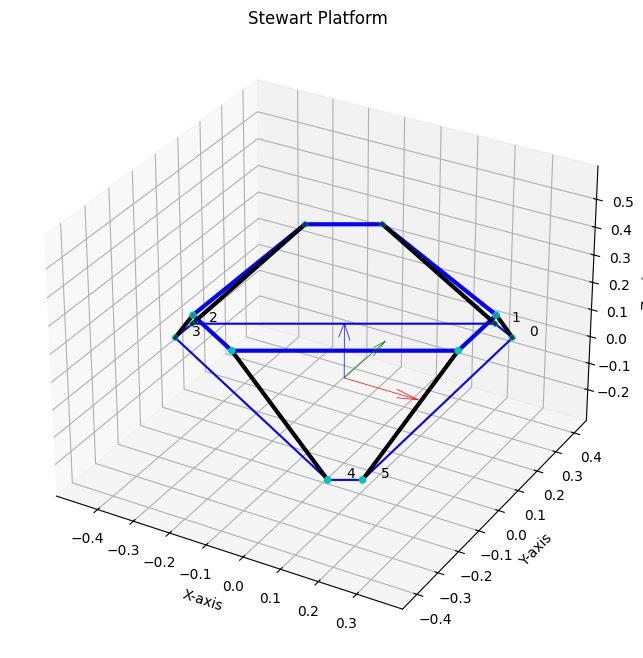

optimal phi_p 30.0
optimal phi_b 110.0
optimal r_b 0.45
GTI:  0.900375823640452


In [90]:
optimal = np.max(Holder[:,3]) # find max GTI
config=np.where(Holder[:,3]==optimal)
optimal_config=Holder[config[0][0],:] # select platform with max GTI

phi_p = optimal_config[0]
phi_b = optimal_config[1]
r_b = optimal_config[2]
r_p = 0.363
N_WS = 5
optimal_platform=StewartPlatform(r_b,phi_b,r_p,phi_p)
optimal_platform.getIK([0,0,0.3,0,0,0])
optimal_platform.plot()
print("optimal phi_p", optimal_config[0])
print("optimal phi_b", optimal_config[1])
print("optimal r_b", optimal_config[2])
print("GTI: ",optimal_config[3])


This is the platform before optimization.

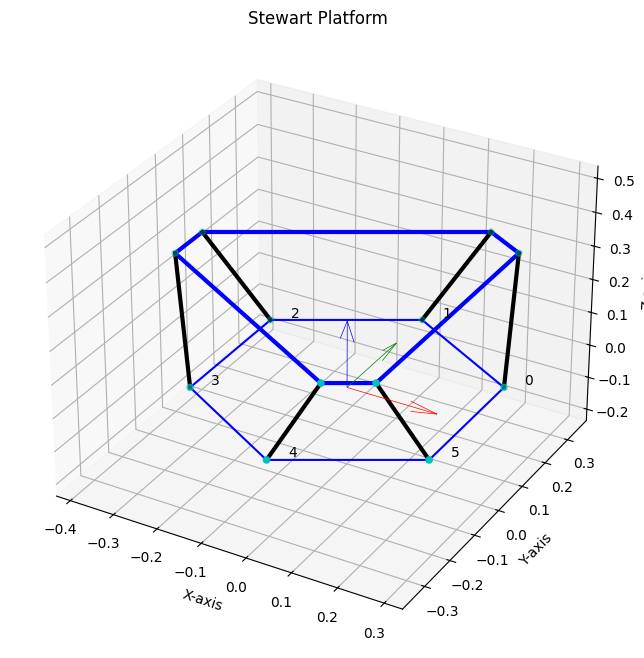

GTI :  0.5713385159185278
The paper says, GTI = 0.576


In [91]:
phi_p = 104
phi_b = 60
r_b = 0.307
r_p = 0.363
N_WS = 5
optimal_paper_platform=StewartPlatform(r_b,phi_b,r_p,phi_p)
position=np.array([0,0,0.3,0,0,0])
optimal_paper_platform.getIK(position)
optimal_paper_platform.plot()
GTI = getGTI(optimal_paper_platform,workspace_limits,orientation_limits,N_WS)
print("GTI : ",GTI)
print("The paper says, GTI = 0.576")